In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier as XGBC
from sklearn.metrics import confusion_matrix as cm, recall_score as recall, roc_auc_score as auc
from sklearn.model_selection import KFold, cross_val_score as CVS, train_test_split as TTS
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import StandardScaler
#warning: 版本兼容性问题

In [2]:
k = 44
data_train = pd.read_csv('/home/yfy/Desktop/projects/NII_image_classify/binary_classification/aug4_train.csv', index_col=0)
# data_val = pd.read_csv('/home/yfy/Desktop/projects/NII_image_classify/binary_classification/aug4_validation.csv', index_col=0)

In [102]:
data_train = pd.read_csv('/home/yfy/Desktop/projects/NII_image_classify/binary_classification/gray_train.csv', index_col=0)
data_val = pd.read_csv('/home/yfy/Desktop/projects/NII_image_classify/binary_classification/gray_validation.csv', index_col=0)
k = 44

In [103]:
Xtrain = data_train.iloc[:,:k]
Ytrain = data_train.iloc[:,-1]
Xval = data_val.iloc[:,:k]
Yval = data_val.iloc[:,-1]
X = pd.concat([Xtrain,Xval],axis=0)
Y = pd.concat([Ytrain,Yval],axis=0)

In [104]:
Xtrain.shape

(1560, 44)

In [105]:
Xval.shape

(520, 44)

In [108]:
# 标准化
Xtrain = StandardScaler().fit_transform(Xtrain)   # fit：计算均值、标准差，transformer能得到标准化之后的数据
Xval = StandardScaler().fit_transform(Xval)
X = StandardScaler().fit_transform(X)

In [113]:
# PCA降维: 9 结果最好
from sklearn.decomposition import PCA

Xtrain_dr = PCA(30,random_state=420).fit_transform(Xtrain)
Xval_dr = PCA(30,random_state=420).fit_transform(Xval)
X_dr = PCA(9,random_state=420).fit_transform(X)

In [114]:
clf = XGBC(n_estimators=27
           ,random_state=420
           ,use_label_encoder=False
           ,eval_metric='error'
           , max_depth=5
          ).fit(Xtrain_dr,Ytrain)

clf.score(Xval_dr,Yval) 

0.6269230769230769

9 0.7442307692307693


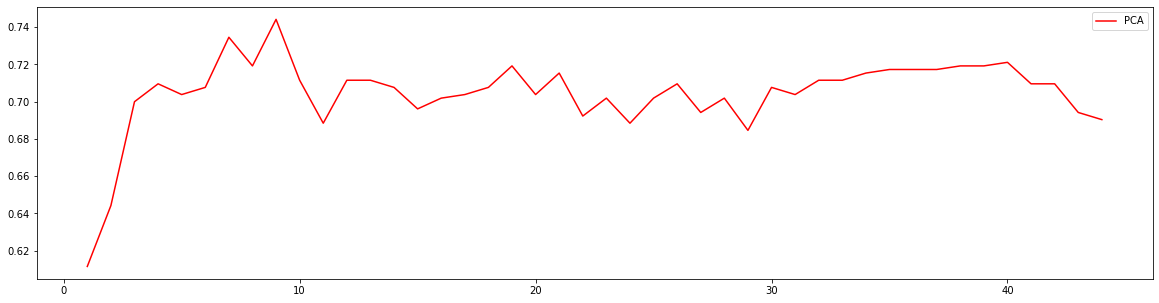

In [34]:
# PCA 的学习曲线
axisx = range(1,45)
rs = []
for i in axisx:
    Xtrain_dr = PCA(i,random_state=420).fit_transform(Xtrain)
    Xval_dr = PCA(i,random_state=420).fit_transform(Xval)
    clf = XGBC(n_estimators=10,random_state=420,use_label_encoder=False, eval_metric='error',max_depth=5)
    clf = clf.fit(Xtrain_dr,Ytrain)
    rs.append(clf.score(Xval_dr,Yval))
print(axisx[rs.index(max(rs))],max(rs))
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="red",label="PCA")
plt.legend()
plt.show()

In [97]:
clf = XGBC(n_estimators=27
           ,random_state=420
           ,use_label_encoder=False
           ,eval_metric='error'
           ,max_depth=5)

In [98]:
CVS(clf,Xtrain_dr,Ytrain,cv=5,scoring='accuracy').mean()

0.777724358974359

In [26]:
# 定义：绘制以样本数量为横坐标的学习曲线函数

def plot_learning_curve(estimator,title, X, y, 
                        ax=None, #选择子图
                        ylim=None, #设置纵坐标的取值范围
                        cv=None, #交叉验证
                        n_jobs=None #设定索要使用的线程
                       ):
    
    from sklearn.model_selection import learning_curve
    import matplotlib.pyplot as plt
    import numpy as np
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y
                                                            ,shuffle=True
                                                            ,cv=cv
                                                            ,random_state=420
                                                            ,n_jobs=n_jobs)      
    if ax == None:
        ax = plt.gca()
    else:
        ax = plt.figure()
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.grid() #绘制网格，不是必须
    ax.plot(train_sizes, np.mean(train_scores, axis=1), 'o-'
            , color="r",label="Training score")
    ax.plot(train_sizes, np.mean(test_scores, axis=1), 'o-'
            , color="g",label="Test score")
    ax.legend(loc="best")
    return ax

In [88]:
cv = KFold(n_splits=5, shuffle = True, random_state=42) #交叉验证模式

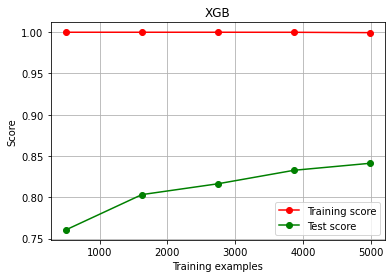

In [28]:
plot_learning_curve(XGBC(n_estimators=100,random_state=420,use_label_encoder=False, eval_metric='error',max_depth=5)
                    ,"XGB",Xtrain_dr,Ytrain,ax=None,cv=cv)
plt.show()

101 0.7461538461538462


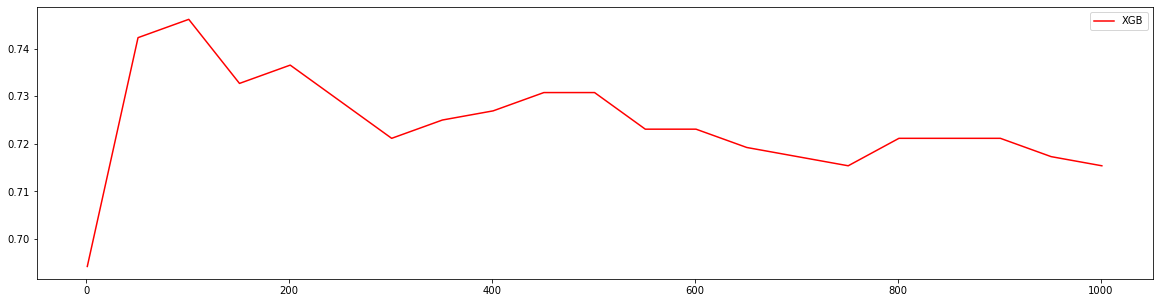

In [63]:
# 根据score的学习曲线 粗调
axisx = range(1,1010,50)
rs = []
for i in axisx:
    clf = XGBC(n_estimators=i,random_state=420,use_label_encoder=False, eval_metric='error',max_depth=5)
    clf = clf.fit(Xtrain_dr,Ytrain)
    rs.append(clf.score(Xval_dr,Yval))
print(axisx[rs.index(max(rs))],max(rs))
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="red",label="XGB")
plt.legend()
plt.show()

27 0.7692307692307693


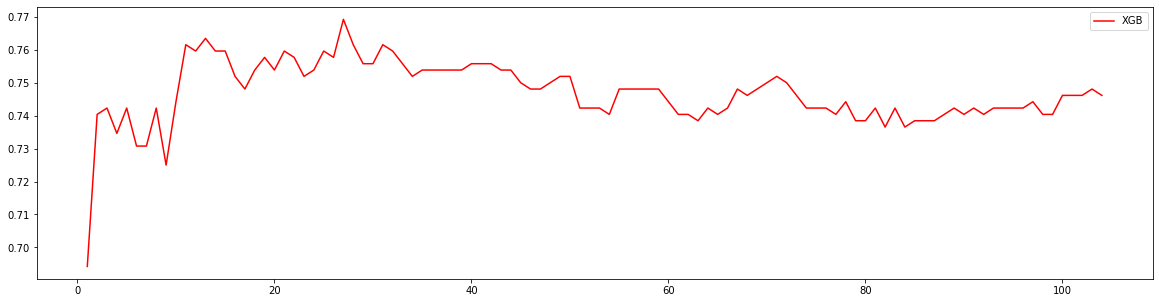

In [68]:
# 根据score的学习曲线 粗调
axisx = range(1,105,1)
rs = []
for i in axisx:
    clf = XGBC(n_estimators=i,random_state=420,use_label_encoder=False, eval_metric='error',max_depth=5)
    clf = clf.fit(Xtrain_dr,Ytrain)
    rs.append(clf.score(Xval_dr,Yval))
print(axisx[rs.index(max(rs))],max(rs))
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="red",label="XGB")
plt.legend()
plt.show()

1.0 0.7692307692307693


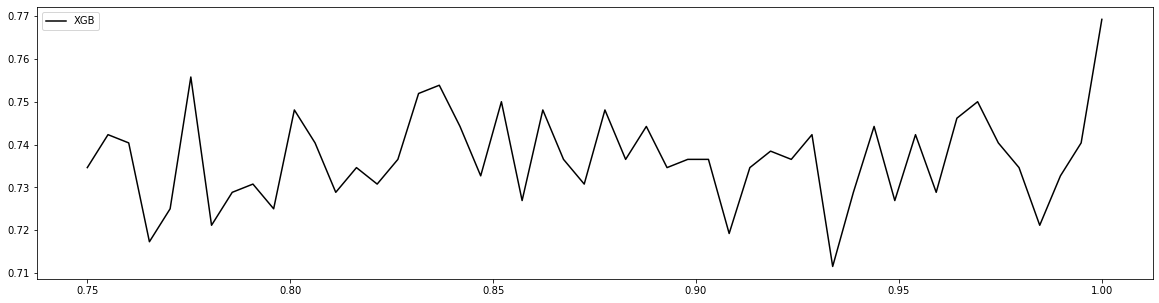

In [74]:
# 随机抽样参数 subsample调整
axisx = np.linspace(0.75,1,50)
rs = []
for i in axisx:
    clf = XGBC(n_estimators=27
               ,subsample=i
               ,random_state=420
               ,use_label_encoder=False
               ,eval_metric='error'
               ,max_depth=5)
    clf = clf.fit(Xtrain_dr,Ytrain)
    rs.append(clf.score(Xval_dr,Yval))
print(axisx[rs.index(max(rs))],max(rs))
rs = np.array(rs)
# var = np.array(var)
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="black",label="XGB")
# plt.plot(axisx,rs+var,c="red",linestyle='-.')
# plt.plot(axisx,rs-var,c="red",linestyle='-.')
plt.legend()
plt.show()

# learning rate

In [83]:
#首先我们先来定义一个评分函数，这个评分函数能够帮助我们直接打印Xtrain上的交叉验证结果
def binary_s(clf,X,Y):
    score = clf.score(X,Y)
    print(score)
    return score

In [ ]:
#首先我们先来定义一个评分函数，这个评分函数能够帮助我们直接打印Xtrain上的交叉验证结果
def regassess(reg,Xtrain,Ytrain,cv,scoring = ["r2"],show=True):
    score = []
    for i in range(len(scoring)):
        if show:
            print("{}:{:.2f}".format(scoring[i] #模型评估指标的名字
                                     ,CVS(reg
                                          ,Xtrain,Ytrain
                                          ,cv=cv,scoring=scoring[i]).mean()))
        score.append(CVS(reg,Xtrain,Ytrain,cv=cv,scoring=scoring[i]).mean())
    return score

In [96]:
from time import time
import datetime

for i in [0,0.2,0.5,1]:
    time0=time()
    clf = XGBC(n_estimators=27
               ,subsample=1
               ,random_state=420
               ,use_label_encoder=False
               ,eval_metric='error'
               ,max_depth=5
               ,learning_rate=0.3
              ).fit(Xtrain_dr,Ytrain)
    print("learning_rate = {}".format(i))
    binary_s(clf,Xval_dr,Yval)
    print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))
    print("\t")

learning_rate = 0
0.7692307692307693
00:00:251380
	
learning_rate = 0.2
0.7692307692307693
00:00:216182
	
learning_rate = 0.5
0.7692307692307693
00:00:224587
	
learning_rate = 1
0.7692307692307693
00:00:215103
	


0.35000000000000003 0.8214743589743589
0.3 0.7692307692307693


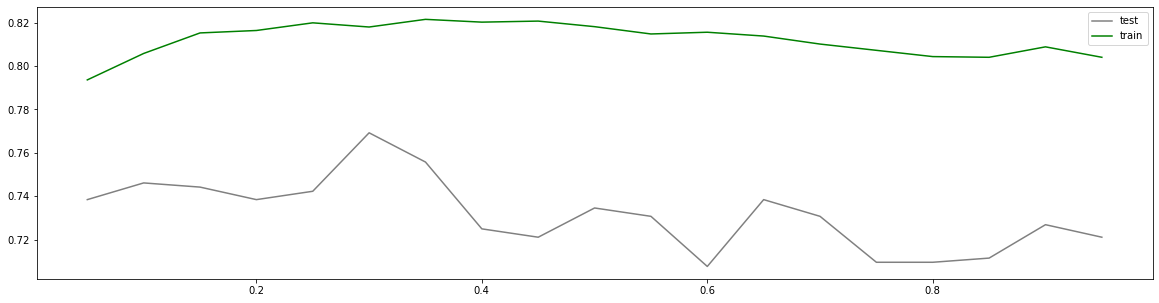

In [94]:
axisx = np.arange(0.05,1,0.05)
rs = []
te = []
for i in axisx:
    clf = XGBC(n_estimators=27
               ,subsample=1
               ,random_state=420
               ,use_label_encoder=False
               ,eval_metric='error'
               ,max_depth=5
               ,learning_rate=i
              )
    score = regassess(clf,Xtrain_dr,Ytrain,cv,scoring = ["accuracy"],show=False)
    test = clf.fit(Xtrain_dr,Ytrain).score(Xval_dr,Yval)
    rs.append(score[0])
    te.append(test)
print(axisx[rs.index(max(rs))],max(rs))
print(axisx[te.index(max(te))],max(te))
plt.figure(figsize=(20,5))
plt.plot(axisx,te,c="gray",label="test")
plt.plot(axisx,rs,c="green",label="train")
plt.legend()
plt.show()

# 评估器

In [101]:
for booster in ["gbtree","gblinear","dart"]:
    clf = XGBC(n_estimators=27
               ,subsample=1
               ,random_state=420
               ,use_label_encoder=False
               ,eval_metric='error'
               ,max_depth=5
               ,learning_rate=0.3
              ).fit(Xtrain_dr,Ytrain)
    print(booster)
    print(clf.score(Xval_dr,Yval))

gbtree
0.7692307692307693
gblinear
0.7692307692307693
dart
0.7692307692307693


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier as XGBC
from sklearn.metrics import confusion_matrix as cm, recall_score as recall, roc_auc_score as auc
from sklearn.model_selection import KFold, cross_val_score as CVS, train_test_split as TTS
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib
from sklearn.model_selection import GridSearchCV

Xtrain, Ytrain, Xval, Yval = joblib.load('/home/yfy/Desktop/projects/NII_image_classify/new_bof_xy.pkl')

Xtrain = np.array(Xtrain)
Ytrain = np.array(Ytrain)
Xval = np.array(Xval)
Yval = np.array(Yval)

clf = XGBC(n_estimators=81 #27
           ,random_state=420
           ,use_label_encoder=False
           ,eval_metric='auc'
           ,max_depth=6  #5
#            ,objective='multi:softmax'
#            ,num_class=2
           ,tree_method='gpu_hist'
          )


clf.fit(Xtrain,Ytrain,eval_set=[(Xval,Yval)])
# clf.fit(Xtrain,Ytrain)
clf.score(Xval,Yval)

from sklearn.model_selection import GridSearchCV

param = {'max_depth':np.arange(1,8,1), 'learning_rate':np.arange(0.05,1,0.05)}
gscv = GridSearchCV(clf,param_grid = param,scoring='accuracy',cv=5)

gscv.fit(Xtrain,Ytrain)

gscv.best_params_

gscv.best_score_
